# NYC Taxi duration

[Kaggle](https://www.kaggle.com/headsortails/nyc-taxi-eda-update-the-fast-the-curious)

In [1]:
import os

import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

## Data Loading

In [2]:
FILEPATH = os.path.join("nyc-taxi-trip-duration", "train.csv")
FILEPATHTEST = os.path.join("nyc-taxi-trip-duration", "test.csv")
FILEPATHSAMPLE = os.path.join("nyc-taxi-trip-duration", "sample_submission.csv")

train = pd.read_csv(FILEPATH)
test = pd.read_csv(FILEPATHTEST)
sample = pd.read_csv(FILEPATHSAMPLE)

In [3]:
test.info()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 no

In [4]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## Data Cleaning
### Gestion des outliers

Aucunes valeurs inexistantes

In [5]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Voyages à vide :

In [6]:
train.loc[train["passenger_count"] == 0].count()
#train = train.loc[train['passenger_count'] > 0]

id                    60
vendor_id             60
pickup_datetime       60
dropoff_datetime      60
passenger_count       60
pickup_longitude      60
pickup_latitude       60
dropoff_longitude     60
dropoff_latitude      60
store_and_fwd_flag    60
trip_duration         60
dtype: int64

Voyages trop courts (moins d'1 minute) :

In [7]:
train.loc[train["trip_duration"] < 60].count()
#train = train.loc[train['trip_duration'] >= 60]

id                    8595
vendor_id             8595
pickup_datetime       8595
dropoff_datetime      8595
passenger_count       8595
pickup_longitude      8595
pickup_latitude       8595
dropoff_longitude     8595
dropoff_latitude      8595
store_and_fwd_flag    8595
trip_duration         8595
dtype: int64

Ou trop longs (environ plus de 3h) :

In [8]:
train.loc[train["trip_duration"] > 11000].count()
#train = train.loc[train['trip_duration'] <= 11000]

id                    2109
vendor_id             2109
pickup_datetime       2109
dropoff_datetime      2109
passenger_count       2109
pickup_longitude      2109
pickup_latitude       2109
dropoff_longitude     2109
dropoff_latitude      2109
store_and_fwd_flag    2109
trip_duration         2109
dtype: int64

### Missing values handling
Pas ou peu de valeurs manquantes

### Scaling des données

#### Formattage datetime

In [9]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

In [10]:
train['hour'] = train.loc[:,'pickup_datetime'].dt.hour;
test['hour'] = test.loc[:,'pickup_datetime'].dt.hour;

#### Calcul de la distance entre pick_up et drop_off
Code partiellemnt repris de David L., d'après [https://stackoverflow.com/a/1502821](https://stackoverflow.com/a/1502821)

In [11]:
def calcul_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    
    # Rayon (equatorial) de la terre : 6378137 m
    m = 6378137* c
    return m

def haversine_distance(x):
    x1, y1 = np.float64(x['pickup_longitude']), np.float64(x['pickup_latitude'])
    x2, y2 = np.float64(x['dropoff_longitude']), np.float64(x['dropoff_latitude'])
    return calcul_distance(x1, y1, x2, y2)

In [24]:
train['distance'] = train[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].apply(haversine_distance, axis=1)
test['distance'] = test[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].apply(haversine_distance, axis=1)

## Data Exploration

Utilisation Heure par heure du service

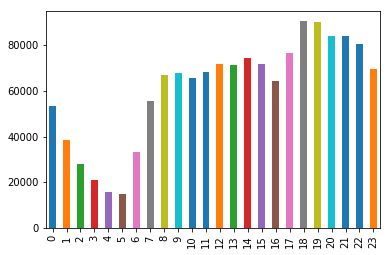

In [13]:
hour_service = pd.value_counts(train['hour']).sort_index()
hour_service.plot.bar()

L'usage évolue bien en fonction des heures de la journée (activité importante entre 17h et 22h)

In [14]:
features_describe = ['passenger_count', 'trip_duration', 'distance', 'hour']
train[features_describe].describe()

,passenger_count,trip_duration,distance,hour
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.664530e+00,9.594923e+02,3.444718e+03,1.360648e+01
std,1.314242e+00,5.237432e+03,4.301351e+03,6.399693e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,3.970000e+02,1.233217e+03,9.000000e+00
50%,1.000000e+00,6.620000e+02,2.096063e+03,1.400000e+01
75%,2.000000e+00,1.075000e+03,3.879679e+03,1.900000e+01
max,9.000000e+00,3.526282e+06,1.242299e+06,2.300000e+01


Probablement des outliers à gérer côté trip_duration et distance

## Features
### Selection
Définition de la target et des paramètres

In [15]:
TARGET = ["trip_duration"]
FEATURES = ["passenger_count","vendor_id", "pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude", "distance", "hour" ]

y_train = train[TARGET]
X_train = train[FEATURES]

## Model Selection

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [17]:
rf = RandomForestRegressor()

## Validation

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, random_state=42)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1093983, 8), (1093983, 1), (364661, 8), (364661, 1))

## Model Training
Train set

In [19]:
rf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [22]:
loss = mean_squared_error(y_valid, rf.predict(X_valid))
loss

16810894.23007635

## Make Prediction
Test set

In [31]:
X_test = test[["vendor_id", "passenger_count","pickup_longitude", "pickup_latitude","dropoff_longitude","dropoff_latitude","distance", "hour"]]
prediction = rf.predict(X_test)
prediction

array([ 779.7,  644. ,  411.5, ..., 1416.5, 1917.9, 1190.9])

In [32]:
export = pd.DataFrame({'id': test.id, 'trip_duration': prediction})
export.head()
export.to_csv('submission.csv', index=False)